# Proyecto VRP

## Estudiantes

### Librerías

In [46]:
import pandas as pd
import numpy as np
import random
import math
import itertools

from functools import cmp_to_key

import seaborn as sns
import matplotlib.pyplot as plt

In [47]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Limpieza de datos

In [129]:
url = '/content/drive/Shareddrives/Bioinspirados/Reto/Data/RC201.xlsx'
df = pd.read_excel(url)
df.head()

,Cust. No,XCOORD,YCOORD,DEMAND,READY_TIME,DUE_DATE,SERVICE_TIME
0,1.0,40.0,50.0,0.0,0.0,960.0,0.0
1,2.0,25.0,85.0,20.0,673.0,793.0,10.0
2,3.0,22.0,75.0,30.0,152.0,272.0,10.0
3,4.0,22.0,85.0,10.0,471.0,591.0,10.0
4,5.0,20.0,80.0,40.0,644.0,764.0,10.0


In [130]:
print(df.isna().sum())

Cust. No        0
XCOORD          0
YCOORD          0
DEMAND          0
READY_TIME      0
DUE_DATE        0
SERVICE_TIME    0
dtype: int64


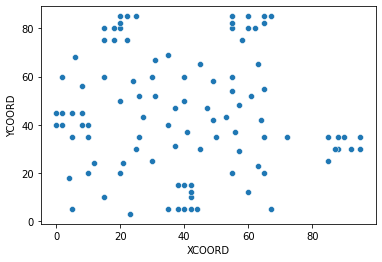

In [131]:
sns.scatterplot( x= df['XCOORD'],y = df['YCOORD'])

In [132]:
df.describe()

,Cust. No,XCOORD,YCOORD,DEMAND,READY_TIME,DUE_DATE,SERVICE_TIME
count,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000
mean,51.000000,40.089109,44.495050,17.069307,367.504950,495.821782,9.900990
std,29.300171,25.153170,24.365395,9.526025,231.613541,233.359996,0.995037
min,1.000000,0.000000,3.000000,0.000000,0.000000,131.000000,0.000000
25%,26.000000,20.000000,29.000000,10.000000,175.000000,311.000000,10.000000
50%,51.000000,40.000000,42.000000,16.000000,349.000000,472.000000,10.000000
75%,76.000000,58.000000,60.000000,20.000000,557.000000,682.000000,10.000000
max,101.000000,95.000000,85.000000,40.000000,822.000000,960.000000,10.000000


In [133]:
minx = 0
miny = 3

maxx = 95
maxy = 85

depot_pos = ((maxx - minx)/2, (maxy - miny)/2)

In [134]:
depot_pos

(47.5, 41.0)

In [135]:
df = df.append({'Cust. No': 0, 'XCOORD': depot_pos[0], 'YCOORD': depot_pos[1], 'DEMAND': 0,'READY_TIME': -1, 'DUE_DATE': -1, 'SERVICE_TIME': -1}, ignore_index = True)

In [136]:
value = (df['XCOORD'] == 47.5) & (df['YCOORD'] == 41.0) 
df['color']= np.where( value==True , "#9b59b6", "#3498db")

In [137]:
df

,Cust. No,XCOORD,YCOORD,DEMAND,READY_TIME,DUE_DATE,SERVICE_TIME,color
0,1.0,40.0,50.0,0.0,0.0,960.0,0.0,#3498db
1,2.0,25.0,85.0,20.0,673.0,793.0,10.0,#3498db
2,3.0,22.0,75.0,30.0,152.0,272.0,10.0,#3498db
3,4.0,22.0,85.0,10.0,471.0,591.0,10.0,#3498db
4,5.0,20.0,80.0,40.0,644.0,764.0,10.0,#3498db
...,...,...,...,...,...,...,...,...
97,98.0,4.0,18.0,35.0,547.0,667.0,10.0,#3498db
98,99.0,26.0,52.0,9.0,172.0,292.0,10.0,#3498db
99,100.0,26.0,35.0,15.0,308.0,428.0,10.0,#3498db
100,101.0,31.0,67.0,3.0,810.0,930.0,10.0,#3498db


In [138]:
df2 = pd.DataFrame({'Cust.No': [1.0, 2.0, 3.0], 'XCOORD': [40, 25, 22], 'YCOORD': [50, 85, 75]})

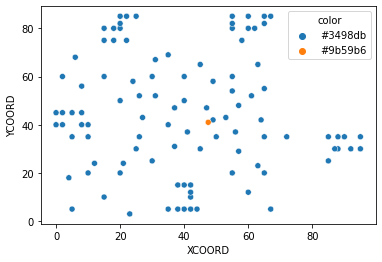

In [139]:
sns.scatterplot( x= df['XCOORD'],y = df['YCOORD'], hue = df['color'])

In [140]:
df_dist =  df[['XCOORD', 'YCOORD']].copy()
df_dist
from scipy.spatial import distance_matrix

matrix = pd.DataFrame(distance_matrix(df_dist.values, df_dist.values), index=df.index, columns=df.index)

In [141]:
fleet = pd.DataFrame({
    'Vehicle': [0, 1, 2, 3, 4],
    'Capacity': [200, 300, 500, 1000, 100]})

In [142]:
fleet

,Vehicle,Capacity
0,0,200
1,1,300
2,2,500
3,3,1000
4,4,100


In [309]:
class Simulation:
  
  def __init__(self, n_individuals, n_iterations, population):
    self.n_individuals = n_individuals
    self.n_iterations = n_iterations
    self.population = population

 
  def run(self):
    self.population.initialize(self.n_individuals)

    for i in range(self.n_iterations):
      self.population.selection()
      self.population.crossover()
      self.population.mutation()
      # print(self.population.population)
    
    tmp = self.population.get_best()
    self.population.plot_solution(tmp)
    

In [384]:
class PopulationVRP:

  def __init__(self, points, vehicles, distance_matrix, mutation_ratio):
    self.points = points
    self.n_points = points.shape[0]

    self.vehicles = vehicles
    self.n_vehicles = vehicles.shape[0]
    self.distance_matrix = distance_matrix
    self.mutation_ratio = mutation_ratio

    self.objectives = [ self.objective_function_2 ]

    self.rate = 0

  def initialize(self, n_individuals):
    self.n_individuals = n_individuals
    self.population = []
    for i in range(self.n_individuals):
      self.population.append(self.generate_chromosome())

    self.childs = []
    for i in range(self.n_individuals):
      self.childs.append(self.generate_chromosome())

    return self.population

  def selection(self):
    candidates = self.population + self.childs

    candidates = sorted(candidates, key = cmp_to_key(self.compare))
        
    # Get the pareto Fronts
    # F = self.get_pareto_fronts(candidates)


    # Obtain the new population with the first Paretos
    # new_population = []
    # minimum = min(len(F)-1, len(self.population))
    # for i in range(minimum):
    #   new_population += F[i]

    # missing_size = len(self.population) - len(new_population)
    # for i in range(missing_size):
      # new_population.append(F[-1][i])

    # self.population = new_population
    for i in range(len(self.population)):
      self.population[i] = candidates[i]
    # print('Population')
    # print(self.population)

  def cxOrdered(self, chromosome1, chromosome2):
    """Executes an ordered crossover (OX) on the input
    individuals. The two individuals are modified in place. This crossover
    expects :term:`sequence` individuals of indices, the result for any other
    type of individuals is unpredictable.
    :param ind1: The first individual participating in the crossover.
    :param ind2: The second individual participating in the crossover.
    :returns: A tuple of two individuals.
    Moreover, this crossover generates holes in the input
    individuals. A hole is created when an attribute of an individual is
    between the two crossover points of the other individual. Then it rotates
    the element so that all holes are between the crossover points and fills
    them with the removed elements in order. For more details see
    [Goldberg1989]_.
    This function uses the :func:`~random.sample` function from the python base
    :mod:`random` module.
    .. [Goldberg1989] Goldberg. Genetic algorithms in search,
       optimization and machine learning. Addison Wesley, 1989
    """
    ind1 = chromosome1.copy()
    ind2 = chromosome2.copy()
    size = len(ind1)
    a, b = random.sample(range(size), 2)
    if a > b:
        a, b = b, a

    holes1, holes2 = [True] * size, [True] * size
    for i in range(size):
        if i < a or i > b:
            holes1[ind2[i]] = False
            holes2[ind1[i]] = False

    # We must keep the original values somewhere before scrambling everything
    temp1, temp2 = ind1, ind2
    k1, k2 = b + 1, b + 1
    for i in range(size):
        if not holes1[temp1[(i + b + 1) % size]]:
            ind1[k1 % size] = temp1[(i + b + 1) % size]
            k1 += 1

        if not holes2[temp2[(i + b + 1) % size]]:
            ind2[k2 % size] = temp2[(i + b + 1) % size]
            k2 += 1

    # Swap the content between a and b (included)
    for i in range(a, b + 1):
        ind1[i], ind2[i] = ind2[i], ind1[i]

    return ind1, ind2

  def crossover(self):
    offspring = []

    for i in range(0,len(self.population),2):
      child1 = []
      child2 = []

      chromosome1 = self.population[i].copy()
      chromosome2 = self.population[i+1].copy()

      child1, child2 = self.cxOrdered(chromosome1, chromosome2)

      offspring.append(child1)
      offspring.append(child2)

    self.childs = offspring

  def mutation(self):
    
    for i in range(len(self.population)):
      tmp = np.random.random()

      if tmp < self.mutation_ratio:
        indx_1 = np.random.randint(0, len(self.population))
        indx_2 = np.random.randint(0, len(self.population))

        self.population[indx_1], self.population[indx_2] = self.population[indx_2], self.population[indx_1]


  def get_pareto_fronts(self, candidates):
    p_fs = []
    n = len(self.population)
    cont = 0
    tmp_population = candidates
    while cont < n:
      tmp_population, front = self.pareto_front(tmp_population)
      cont += len(front)
      p_fs.append(front)

    return p_fs

  def pareto_front(self, population):
    remove = np.zeros(len(population))
    f = []

    for i in range(len(population)):
      domina = True 
      for j in range(len(population)):
        if i != j:
          if (self.dominates(population[i], population[j]) == False and
              self.dominates(population[j], population[i]) == True):
            domina = False

      if domina == True:
        f.append(population[i])
        remove[i] = 1

    new_population = []
    for i in range(len(population)):
      if remove[i] == 0:
        new_population.append(population[i])

    return new_population, f

  def is_feasible_solution(self, chromosome):
    """
      Check wether the chromosome represents or not a feasible solution
    """
    pass


  def dominates(self, chromosome_a, chromosome_b):
    """
      Returns -1 if the chromosome A dominates the chromosome B, 1 if A dominates
      B and 0 in the case all fitness functions of all objectives have the same
      value. In this case we want to minimize both objective, thus, inequality
      is lower than
    """
    a_no_worse_b = 0
    a_strictly_better_b = 0

    for i in range(len(self.objectives)):
      value1 = self.objectives[i](chromosome_a)
      value2 = self.objectives[i](chromosome_b)

      if value1 <= value2:
        a_no_worse_b += 1
        a_strictly_better_b += 1
      elif value1 == value2:
        a_no_worse_b += 1
      else:
        return False

    return a_no_worse_b == len(self.objectives) and a_strictly_better_b >=1

  def compare(self, chromosome_a, chromosome_b):
    if self.objective_function_2(chromosome_a) < self.objective_function_2(chromosome_b):
      return -1
    
    if self.objective_function_2(chromosome_a) == self.objective_function_2(chromosome_b):
      return 0

    return 1

  def objective_function_1(self, chromosome):
    int_list = []
    for element in chromosome:
      x = math.modf(element)
      int_list.append(x[1])

      num_value = len(set(int_list))

    return num_value

  def objective_function_2(self, chromosome):
    distance = 0
    for i in range(len(chromosome)-1):
      distance += self.distance_matrix[chromosome[i]][chromosome[i+1]]

    # print('Distance')
    # print(distance)
    return distance


  def generate_chromosome(self):
    chromosome = np.arange(0, self.n_points)
    np.random.shuffle(chromosome)

    return chromosome

  def get_best(self):
    # print('Final population')
    # print(self.population)
    F = self.pareto_front(self.population + self.childs)[1]
    # print('Best solutions')
    # print(len(F))
    return F[0]

  def plot_solution(self, solution):

    print(solution)
    points_x = []
    points_y = []
    for point in solution:
      points_x.append(self.points['XCOORD'].iloc[point])
      points_y.append(self.points['YCOORD'].iloc[point])
      
    plt.plot(points_x, points_y)
    sns.scatterplot(x = points_x, y = points_y)

    plt.show()

In [402]:
population_vrp = PopulationVRP(
    points = df[0:25],
    vehicles = fleet,
    distance_matrix = matrix,
    mutation_ratio = 99
)

In [403]:
sim = Simulation(
    n_individuals = 20,
    n_iterations = 1000,
    population = population_vrp
)

[10 17  0  5 16 18 19 21 22 24 13 20 23  4  6  7  8  2  3  1 14 15  9 11
 12]


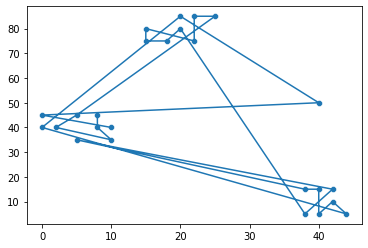

In [404]:
sim.run()